In [69]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: Tesla P100-PCIE-12GB


## Classification procedure for participant B, Suturing task

In [102]:
def evaluate_model(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(X, y, groups):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        if cm.shape != (ngestures,ngestures):
            missing_gestures = set(gestures) - set(preds) - set(y[test_index])
            l = cm.shape[0]
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, np.zeros(l), axis=1)
                cm = np.insert(cm, gi, np.zeros(l+1), axis=0)
                cm[gi,gi] = 1
                l = l+1

        confusion_matrix_cum += cm/nsplits
    accuracy = np.mean(np.diag(confusion_matrix_cum))

    return accuracy, confusion_matrix_cum

In [3]:
ncomp = 10
task = 2
subject = 'B'

### Data distribution 

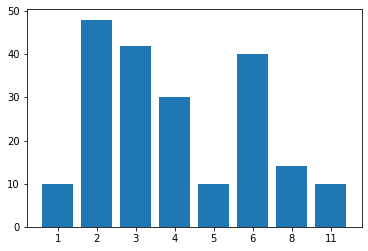

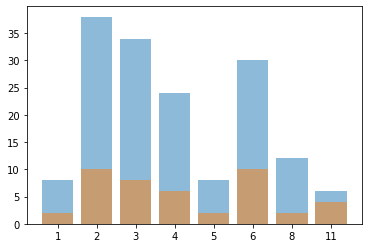

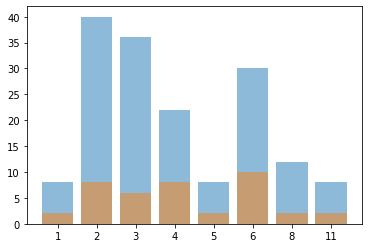

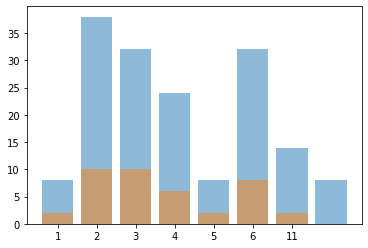

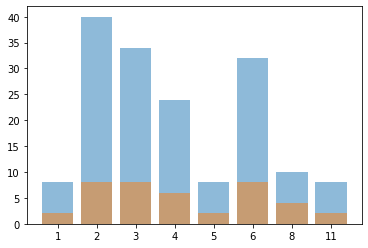

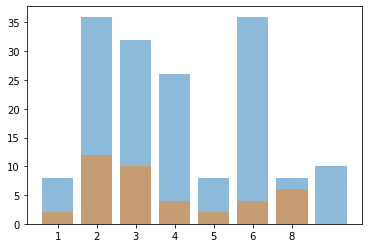

In [151]:
nsplits = 5
nsample_per_group = int(nsample/nsplits)
repeats = [nsample_per_group]*(nsplits-1)
repeats = repeats + [nsample-np.sum(repeats)]
groups = np.repeat(np.arange(nsplits), repeats)
kfolder = GroupKFold(n_splits=nsplits)

def plot_distr(classes, counts, alpha=1):
    nclass = len(classes)
    x = range(nclass)
    plt.bar(x, counts, alpha=alpha)
    plt.xticks(x, classes)

plot_distr(*np.unique(y, return_counts=True))
plt.show()
for train_index, test_index in kfolder.split(X, y, groups):
    plot_distr(*np.unique(y[train_index], return_counts=True), alpha=0.5)
    plot_distr(*np.unique(y[test_index], return_counts=True), alpha=0.5)
    plt.show()

### Points creation for baseline

In [4]:
video_data, y = load_video_data(tasks=task, subjects=subject)
nsample = len(y)
gestures = np.unique(y)
ngestures = len(gestures)
g2i = {g: i for i, g in enumerate(gestures)}
X = []
for video in video_data:
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))

### Computation of all distances for baseline

In [6]:
full_martin_gram = np.zeros((len(X), len(X)))
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_martin_gram[i,j] = full_martin_gram[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            if martin_dist(mi, mj) < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_martin_gram[i,j] = martin_dist(mi, mj)
full_martin_gram[full_martin_gram < 0] = 0

#### KNN

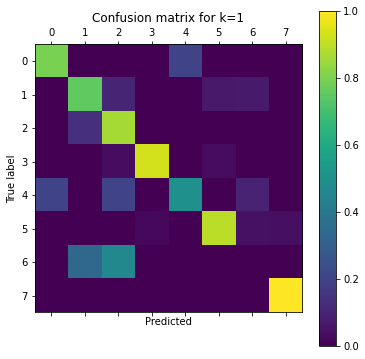

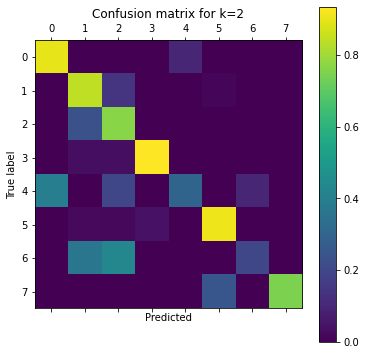

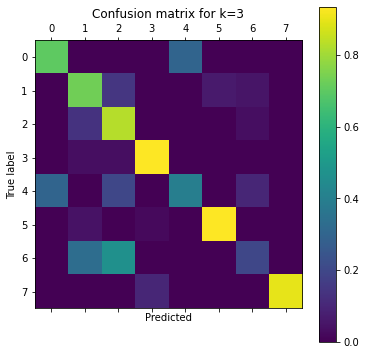

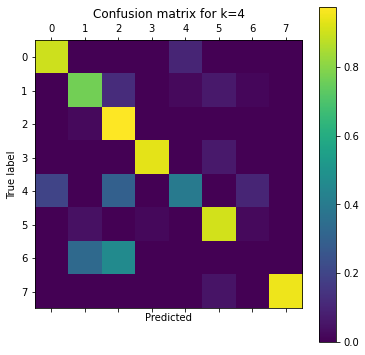

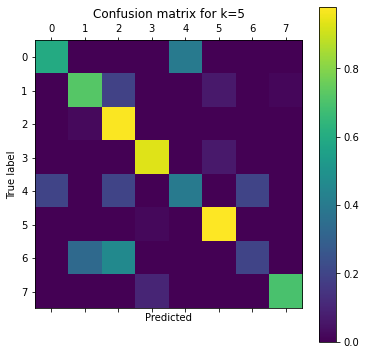

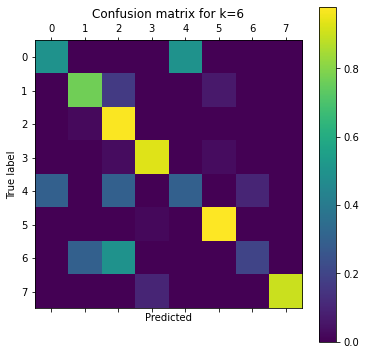

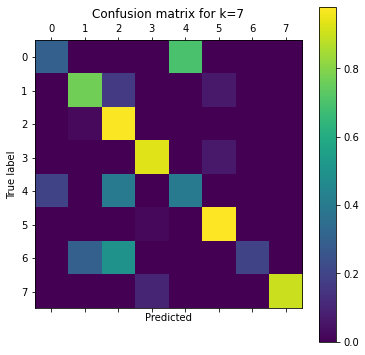

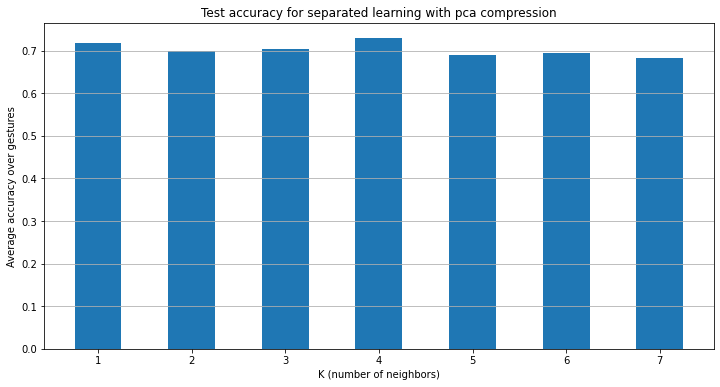

In [28]:
ks = np.arange(1, 8)
confusions_baseline_knn = np.zeros((len(ks), ngestures, ngestures))
accuracies_baseline_knn = np.zeros(len(ks))
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=4)
    accuracy, conf_matrix = evaluate_model(knn, full_martin_gram, y)
    accuracies_baseline_knn[ki] = accuracy
    confusions_baseline_knn[ki] = conf_matrix

for ki, k in enumerate(ks):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_baseline_knn[ki], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for k={k}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression')
plt.bar(ks, accuracies_baseline_knn, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('K (number of neighbors)')
plt.grid(axis='y')

#### SVM

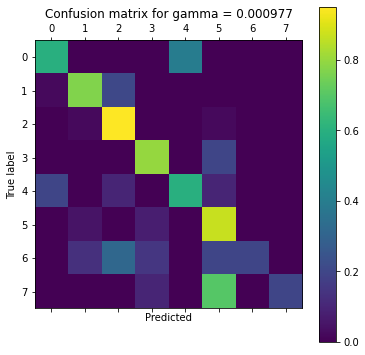

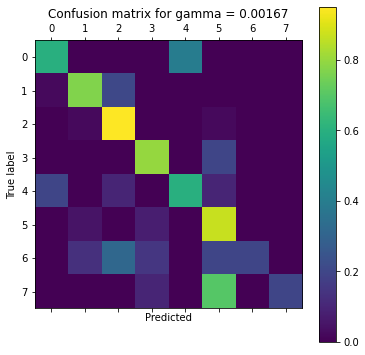

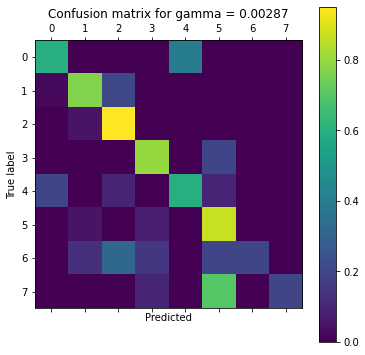

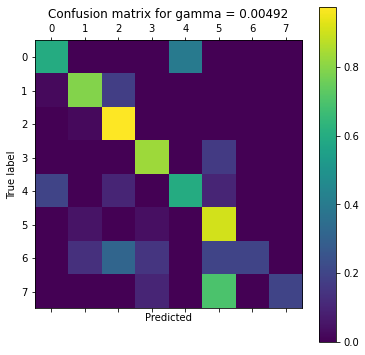

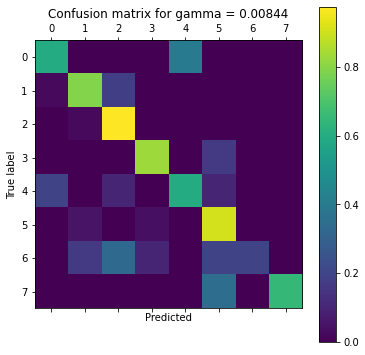

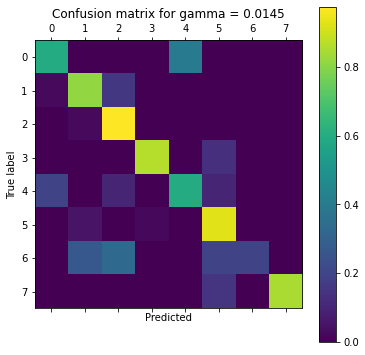

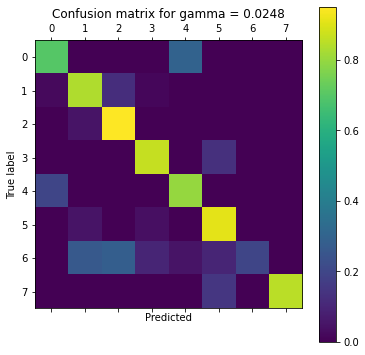

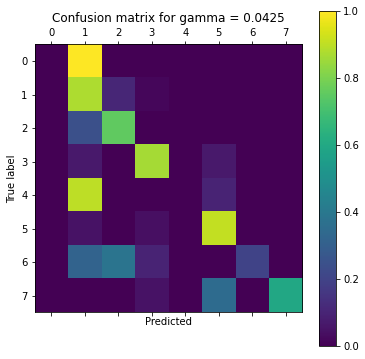

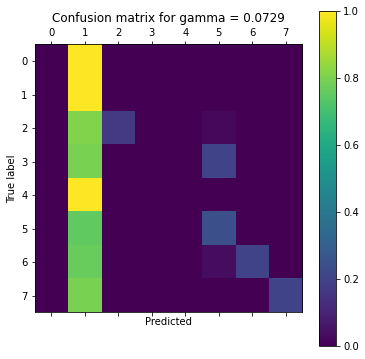

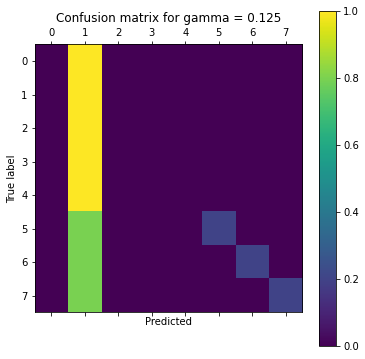

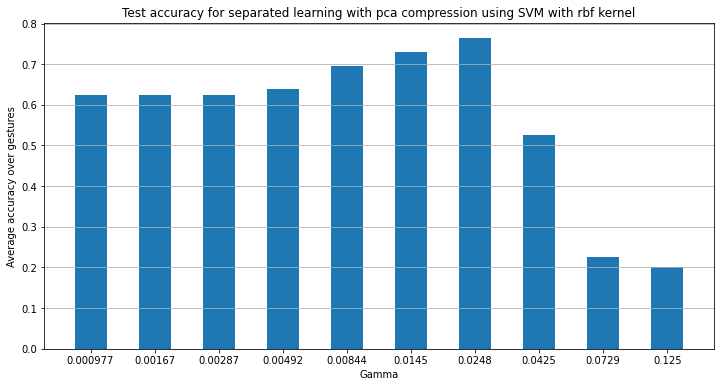

In [63]:
svm_model = SVC()
gammas = np.logspace(-10, -3, base=2, num=10)

confusions_baseline_svm = np.zeros((len(gammas), ngestures, ngestures))
accuracies_baseline_svm = np.zeros(len(gammas))
for gammai, gamma in enumerate(gammas):
    accuracy, conf_matrix = evaluate_model(svm_model, full_martin_gram, y, d_transform=lambda x: np.exp(-gamma*x))
    accuracies_baseline_svm[gammai] = accuracy
    confusions_baseline_svm[gammai] = conf_matrix

for gammai, gamma in enumerate(gammas):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_baseline_svm[gammai], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for gamma = {gamma:.3}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression using SVM with rbf kernel')
gammas_str = [f'{float(f"{gamma:.3g}"):g}' for gamma in gammas]
plt.bar(gammas_str, accuracies_baseline_svm, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('Gamma')
plt.grid(axis='y')

#### SVM with class weights

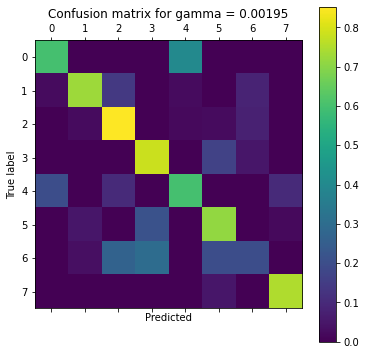

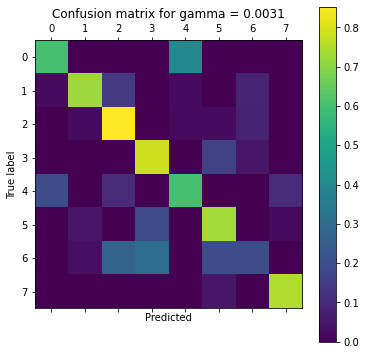

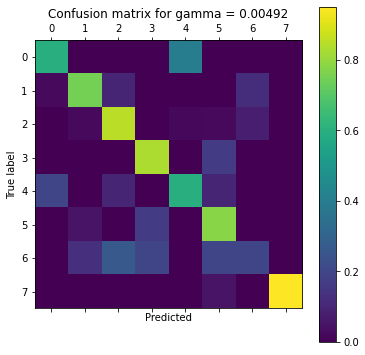

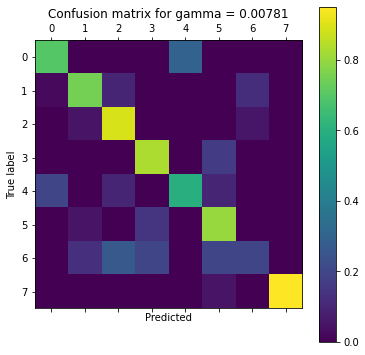

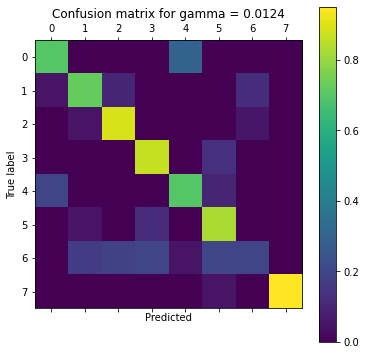

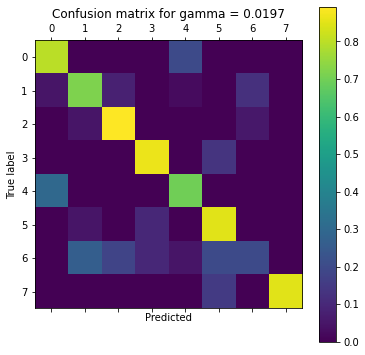

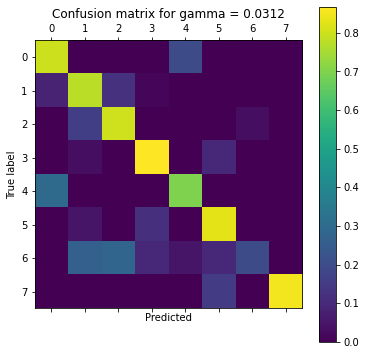

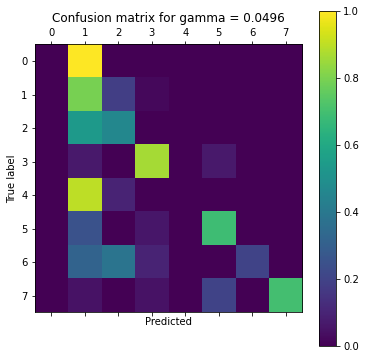

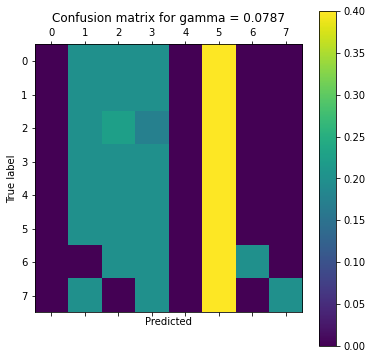

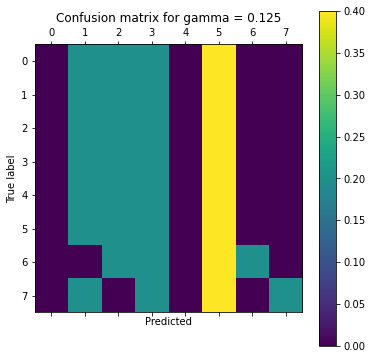

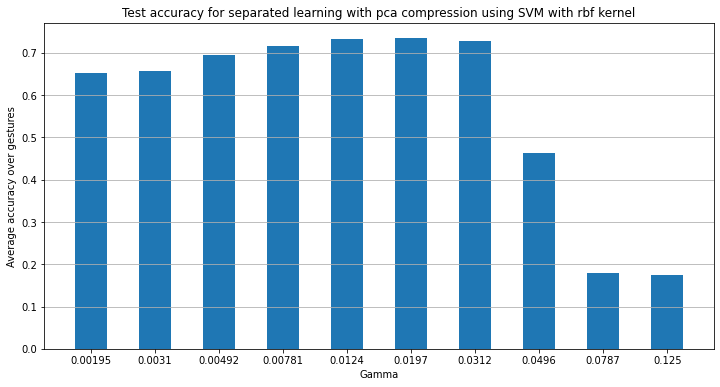

In [157]:
svm_model = SVC(class_weight='balanced')
gammas = np.logspace(-9, -3, base=2, num=10)

confusions_baseline_svm = np.zeros((len(gammas), ngestures, ngestures))
accuracies_baseline_svm = np.zeros(len(gammas))
for gammai, gamma in enumerate(gammas):
    accuracy, conf_matrix = evaluate_model(svm_model, full_martin_gram, y, d_transform=lambda x: np.exp(-gamma*x))
    accuracies_baseline_svm[gammai] = accuracy
    confusions_baseline_svm[gammai] = conf_matrix

for gammai, gamma in enumerate(gammas):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_baseline_svm[gammai], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for gamma = {gamma:.3}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression using SVM with rbf kernel')
gammas_str = [f'{float(f"{gamma:.3g}"):g}' for gamma in gammas]
plt.bar(gammas_str, accuracies_baseline_svm, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('Gamma')
plt.grid(axis='y')

### Points creation for pca autoencoder

In [71]:
class FramePredictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.predictor = nn.Linear(model.ncomp, model.ncomp)

    def forward(self, x):
        shape = x.shape
        x = self.predictor(x.view(x.shape[0], -1))

        return x.view(shape)

In [91]:
video_data, y = load_video_data(tasks=task, subjects=subject)
nsample = len(y)
gestures = np.unique(y)
ngestures = len(gestures)
g2i = {g: i for i, g in enumerate(gestures)}
X_pcaae = []
losses_gain_pcaae = np.zeros((nsample, 2))
for vi, video in enumerate(video_data):
    # Train PCA
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
    pca_model = custom_pca(ncomp)
    pca_model.fit(all_frames)
    frames_enc, shape = pca_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    video.torch = True

    # Initialize PCA autoencoder and frame predictor
    np.random.seed(seed)
    torch.manual_seed(seed)
    compression_model = PCAAutoEncoder((1, video.height, video.width), ncomp, pca_model.mean, pca_model.std)
    state_dict = compression_model.state_dict()
    state_dict['to_lower_rep.weight'] = torch.from_numpy(pca_model.C.T)
    state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
    state_dict['from_lower_rep.weight'] = torch.from_numpy(pca_model.C)
    state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
    compression_model.load_state_dict(state_dict)
    compression_model = compression_model.to(device)

    model_ds = FramePredictor(compression_model)
    state_dict = model_ds.state_dict()
    state_dict['predictor.weight'] = torch.from_numpy(A.T)
    state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
    model_ds.load_state_dict(state_dict)
    model_ds = model_ds.to(device)

    # Compute original loss
    all_frames_pred = []
    for frames in video:
        frames = frames.to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)
    all_frames_pred = all_frames_pred[:-1]
    original_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

    # Fine tune
    np.random.seed(seed)
    torch.manual_seed(seed)
    iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)
    optimizer = Adam(list(compression_model.parameters())+list(model_ds.parameters()), lr=2e-7)
    losses = []
    losses.append(original_loss)
    for epoch in range(15):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            frames_next_gt = frames[1:]
            frames_enc = compression_model.encode(frames[:-1])
            frames_next = compression_model.decode(model_ds(frames_enc))
            frames_next = frames_next

            loss = crit(frames_next, frames_next_gt)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(epoch_loss/iteration_per_epoch)

    # Compute resulting loss
    all_frames_pred = []
    for frames in video:
        frames = frames.to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)
    all_frames_pred = all_frames_pred[:-1]
    resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

    X_pcaae.append((compression_model, A))
    losses_gain_pcaae[vi] = (original_loss, resulting_loss)

### Computation of all distances for pca autoencoder

In [95]:
full_martin_gram_pcaae = np.zeros((nsample, nsample))
for i, mi in enumerate(X_pcaae):
    for j, mj in enumerate(X_pcaae):
        if i > j:
            full_martin_gram_pcaae[i,j] = full_martin_gram_pcaae[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            d = martin_dist(mi, mj, C_key='from_lower_rep.weight')
            if d < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_martin_gram_pcaae[i,j] = d
full_martin_gram_pcaae[full_martin_gram_pcaae < 0] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


#### KNN

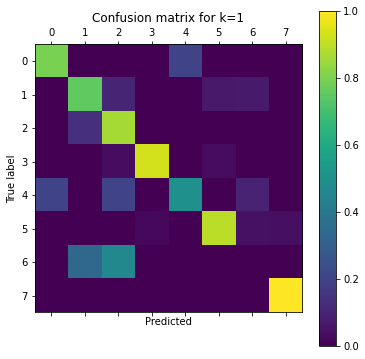

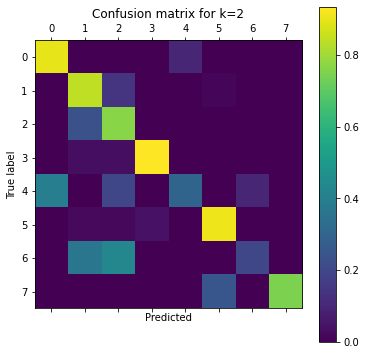

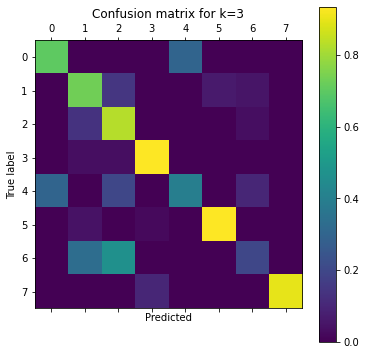

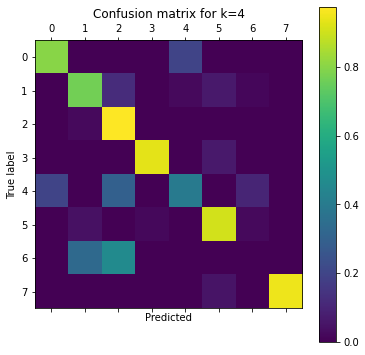

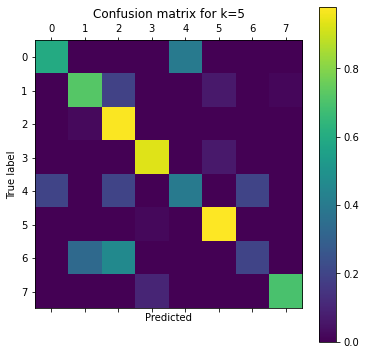

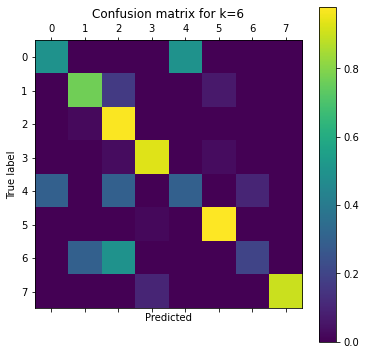

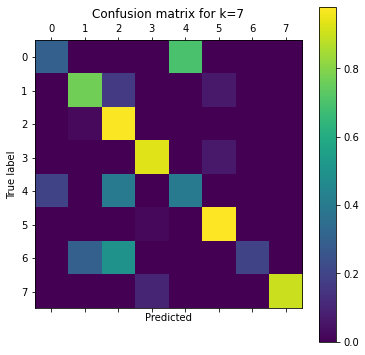

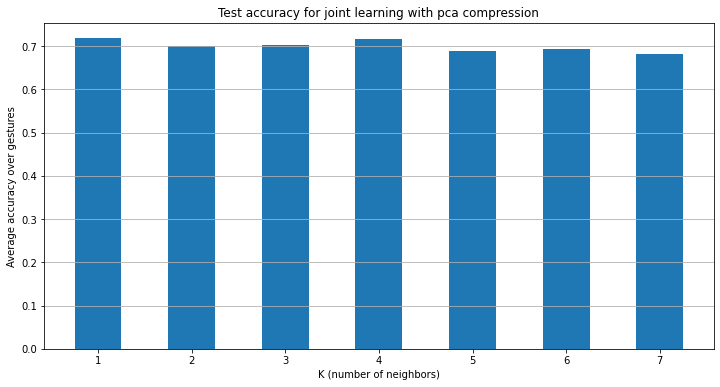

In [104]:
ks = np.arange(1, 8)
confusions_pcaae_knn = np.zeros((len(ks), ngestures, ngestures))
accuracies_pcaae_knn = np.zeros(len(ks))
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=4)
    accuracy, conf_matrix = evaluate_model(knn, full_martin_gram_pcaae, y)
    accuracies_pcaae_knn[ki] = accuracy
    confusions_pcaae_knn[ki] = conf_matrix

for ki, k in enumerate(ks):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_pcaae_knn[ki], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for k={k}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for joint learning with pca compression')
plt.bar(ks, accuracies_pcaae_knn, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('K (number of neighbors)')
plt.grid(axis='y')

#### SVM

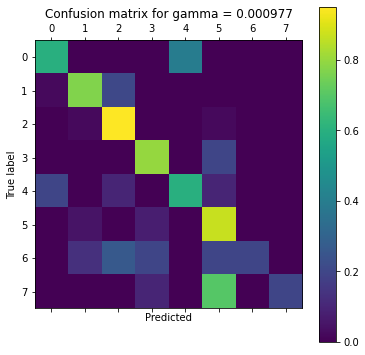

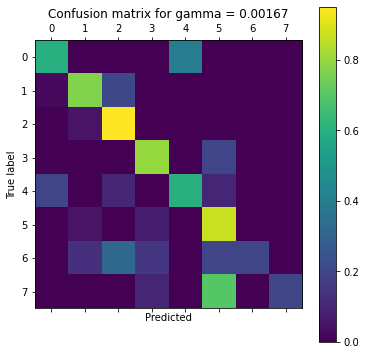

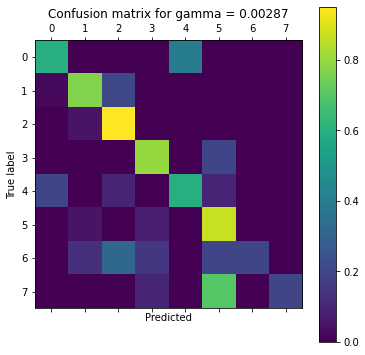

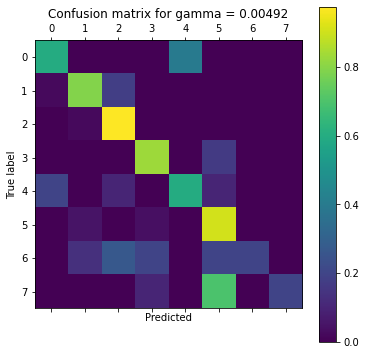

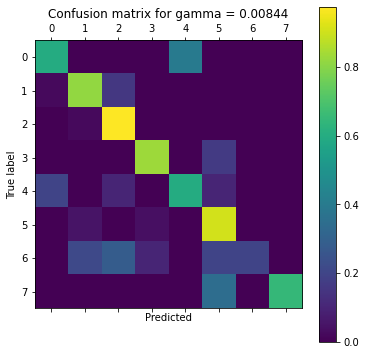

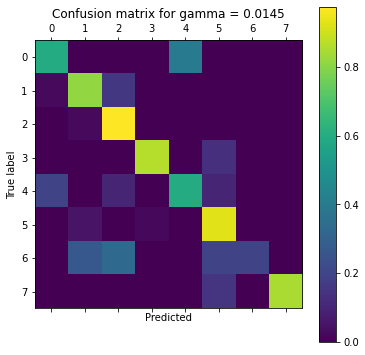

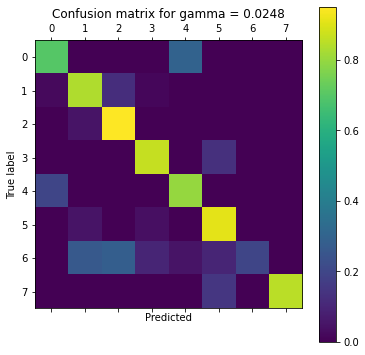

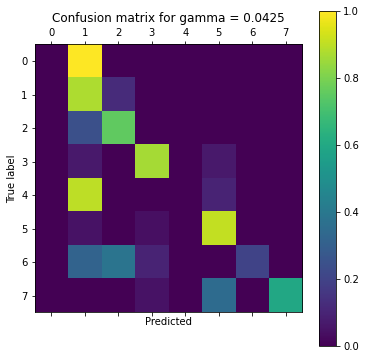

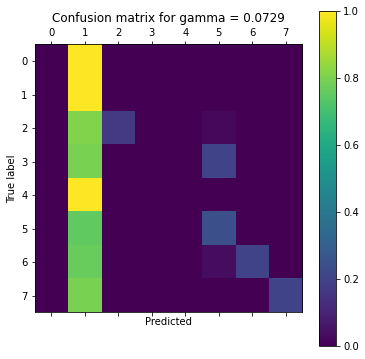

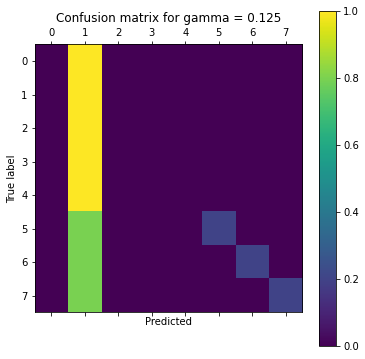

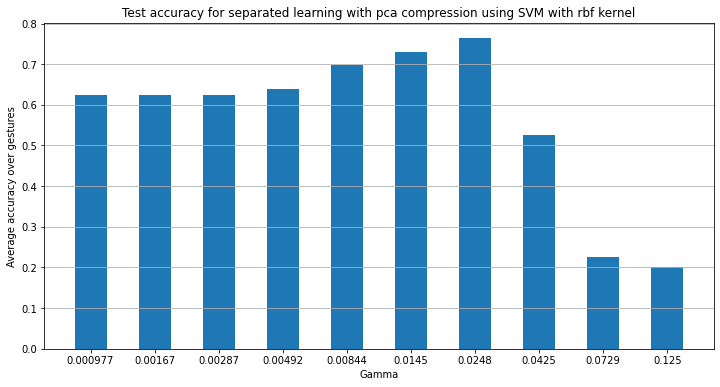

In [105]:
svm_model = SVC()
gammas = np.logspace(-10, -3, base=2, num=10)

confusions_pcaae_svm = np.zeros((len(gammas), ngestures, ngestures))
accuracies_pcaae_svm = np.zeros(len(gammas))
for gammai, gamma in enumerate(gammas):
    accuracy, conf_matrix = evaluate_model(svm_model, full_martin_gram_pcaae, y, d_transform=lambda x: np.exp(-gamma*x))
    accuracies_pcaae_svm[gammai] = accuracy
    confusions_pcaae_svm[gammai] = conf_matrix

for gammai, gamma in enumerate(gammas):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_pcaae_svm[gammai], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for gamma = {gamma:.3}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression using SVM with rbf kernel')
gammas_str = [f'{float(f"{gamma:.3g}"):g}' for gamma in gammas]
plt.bar(gammas_str, accuracies_pcaae_svm, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('Gamma')
plt.grid(axis='y')